# ME Assignment
1. Implement the EM algorithm for clustering with multivariate Gaussian models
discussed in the LearningGM section. Initialize the algorithm with the K-means result
(for example Matlab provides a kmeans function). Assume there are only two clusters.
Report the parameters $\pi_k$, $\mu_k$, $\Sigma_k$, $k = 1, 2$ for the following datasets containing
$500-600$ observations from $\mathbb{R}^2$:



#### Import dependencies

In [407]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from os.path import join
from scipy.stats import multivariate_normal
from itertools import repeat
from random import randint

#### Data loading functions

In [408]:
def get_xeasy():
    return load_data("xeasy.txt")

def get_x1():
    return load_data("x1.txt")

def get_x2():
    return load_data("x2.txt")

def load_data(filename):
    path = "data/EM/"
    data = np.loadtxt(join(path,filename), delimiter=',')
    return data


#### EM Algorithm

In [409]:
def EM(data, num_clusters, ):
    #use kmeans to initialize cluster centers
    kmeans = KMeans(n_clusters=num_clusters)
    prediction_labels = np.asarray(kmeans.fit_predict(data))
    cluster_centroids = np.asarray(kmeans.cluster_centers_)
    cluster_variances = np.asarray([np.sum(np.square(data[prediction_labels==k]))/(prediction_labels.size-1)
                         for k in range(num_clusters)])
    mixture_proportions = np.asarray([np.sum(prediction_labels==k)/prediction_labels.size for k in range(num_clusters)])

    return EM_loop(data,cluster_centroids, cluster_variances, mixture_proportions, num_clusters)

def print_EM(data):
    cluster_centroids, cluster_variances, mixture_proportions, ll_list = EM(data, 2)
    print("Cluster centroids (mu):\n", cluster_centroids)
    print("Cluster Covariances (sigma):\n", cluster_variances)
    print("Proportions (pi):\n",mixture_proportions)
    plt.plot(ll_list)
    plt.title("Loss vs iteration")
    plt.show()

def EM_loop(data,cluster_centroids, cluster_variances, mixture_proportions, num_clusters):
    converged = False
    counter = 0
    ll_list = []
    while not converged:
        counter += 1
        if counter == 10000:
            break
        # expectation step
        denominator = np.sum(np.asarray(list(map(pdf, repeat(data), cluster_centroids, cluster_variances, mixture_proportions))), axis=0)
        prediction_labels=[pdf(data, centroid, variance, proportion)/denominator for centroid, variance, proportion in
                           zip(cluster_centroids, cluster_variances, mixture_proportions)]
        prediction_labels = np.asarray(prediction_labels).T

        # maximization step
        new_cluster_centroids = np.asarray([np.average(data, weights=prediction_labels[:,k], axis=0) for k in range(num_clusters)])
        new_mixture_proportions = np.asarray([np.mean(prediction_labels[:,k]) for k in range(num_clusters)])
        new_cluster_variances = np.asarray([prediction_labels[:,k]*(data-cluster_centroids[k]).T@(data-cluster_centroids[k])/np.sum(prediction_labels[:,k])
                         for k in range(num_clusters)])

        # check if converged
        if(np.allclose(new_cluster_centroids, cluster_centroids) and
           np.allclose(new_cluster_variances, cluster_variances) and
           np.allclose(new_mixture_proportions, mixture_proportions)):
            converged = True

        # update parameters
        cluster_centroids = new_cluster_centroids
        cluster_variances = new_cluster_variances
        mixture_proportions = new_mixture_proportions

        ll = -np.sum(np.log(np.sum(list(map(pdf, repeat(data), cluster_centroids, cluster_variances, mixture_proportions)),axis=0)))
        ll_list.append(ll)
    # uncomment to see plot
    plot_clusters(data, prediction_labels)
    return cluster_centroids, cluster_variances, mixture_proportions, ll_list

def print_proven_EM(data):
    cluster_centroids, cluster_variances, mixture_proportions, ll_list = EM(data, 8)

    # remove all clusters with proportion < .25
    cluster_centroids = cluster_centroids[mixture_proportions<.25]
    cluster_variances = cluster_variances[mixture_proportions<.25]
    mixture_proportions = mixture_proportions[mixture_proportions<.25]

    # select most distance centers
    random_index = randint(0, mixture_proportions.size-1)
    furthest_index = np.argmax(np.linalg.norm(cluster_centroids - cluster_centroids[random_index]))
    indexes_to_keep = [random_index, furthest_index]

    cluster_centroids = cluster_centroids[indexes_to_keep]
    cluster_variances = cluster_variances[indexes_to_keep]
    mixture_proportions = mixture_proportions[indexes_to_keep]

    cluster_centroids, cluster_variances, mixture_proportions, ll_list = \
        EM_loop(data,cluster_centroids, cluster_variances, mixture_proportions, 2)

    print("Cluster centroids (mu):\n", cluster_centroids)
    print("Cluster Covariance (sigma):\n", cluster_variances)
    print("Proportions (pi):\n",mixture_proportions)
    plt.title("Loss vs iteration")
    plt.plot(ll_list)
    plt.show()

def pdf(data, centroid, variance, proportion):
    return multivariate_normal.pdf(data, centroid, variance)*proportion

def plot_clusters(data, prediction_labels):
    # Show scatterplot with labels
    for prediction in prediction_labels.T:
        group = data[prediction > 1/prediction_labels.shape[1]]
        plt.scatter(group[:,0], group[:,1])
    plt.show()


## 1a. xeasy


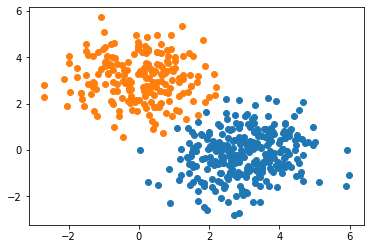

Cluster centroids (mu):
 [[ 3.01886079 -0.17711201]
 [ 0.02847698  3.07051184]]
Cluster Covariances (sigma):
 [[[ 1.00528737  0.16007202]
  [ 0.16007202  0.94210842]]

 [[ 1.01849521 -0.05861085]
  [-0.05861085  0.95457513]]]
Proportions (pi):
 [0.59115761 0.40884239]


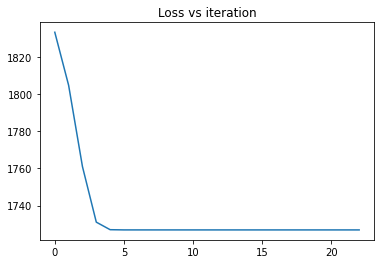

In [410]:
print_EM(get_xeasy())

## 1b. x1


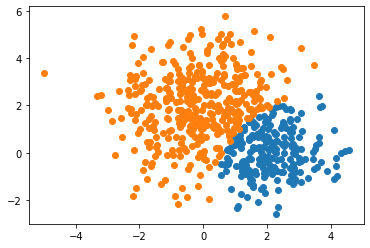

Cluster centroids (mu):
 [[ 2.08440666  0.12438041]
 [-0.10044306  1.97314687]]
Cluster Covariances (sigma):
 [[[ 0.86255332 -0.03892018]
  [-0.03892018  1.0582784 ]]

 [[ 1.70416786  0.148648  ]
  [ 0.148648    2.19990436]]]
Proportions (pi):
 [0.34725828 0.65274172]


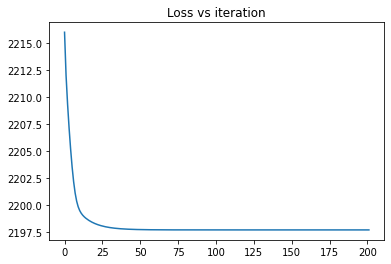

In [411]:
print_EM(get_x1())

## 1c. x2


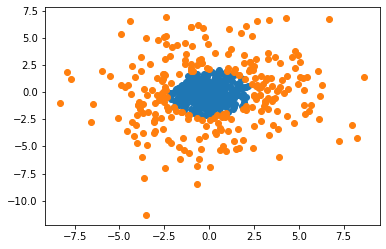

Cluster centroids (mu):
 [[ 0.01424412 -0.04651444]
 [ 0.17809451 -0.12519429]]
Cluster Covariances (sigma):
 [[[1.06250563 0.06633618]
  [0.06633618 0.88826237]]

 [[9.25806322 0.76781936]
  [0.76781936 9.41427379]]]
Proportions (pi):
 [0.51196435 0.48803565]


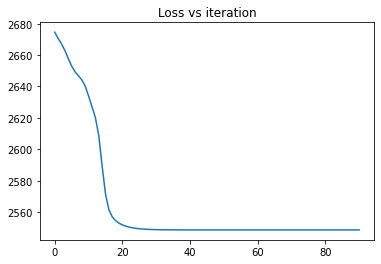

In [412]:
print_EM(get_x2())

## 2a. xeasy


In [ ]:
print_proven_EM(get_xeasy())

## 2b. x1


In [ ]:
print_proven_EM(get_x1())

## 2c. x2


In [ ]:
print_proven_EM(get_x2())


print_proven_EM(get_x2())


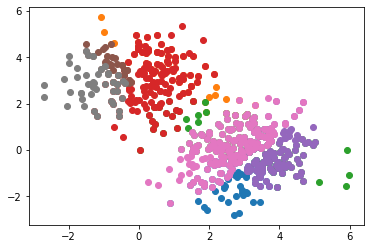

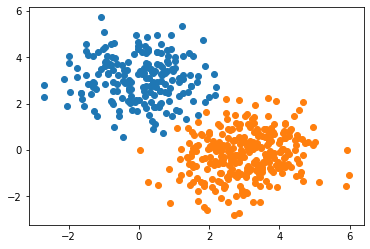

Cluster centroids (mu):
 [[ 0.02847689  3.07051194]
 [ 3.01886073 -0.17711195]]
Cluster Covariance (sigma):
 [[[ 1.0184951  -0.05861072]
  [-0.05861072  0.95457498]]

 [[ 1.00528744  0.16007194]
  [ 0.16007194  0.94210849]]]
Proportions (pi):
 [0.40884236 0.59115764]


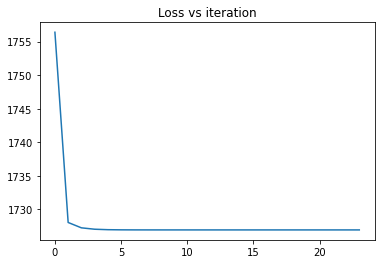

In [413]:
print_proven_EM(get_xeasy())

## 2b. x1


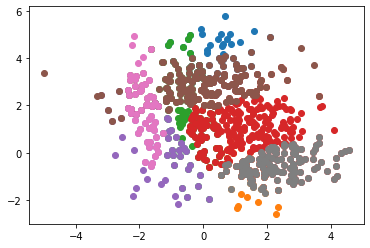

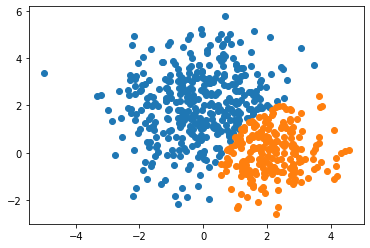

Cluster centroids (mu):
 [[-0.10044329  1.97314703]
 [ 2.08440647  0.12438063]]
Cluster Covariance (sigma):
 [[[ 1.70416765  0.14864823]
  [ 0.14864823  2.19990433]]

 [[ 0.86255344 -0.03892026]
  [-0.03892026  1.05827864]]]
Proportions (pi):
 [0.65274162 0.34725838]


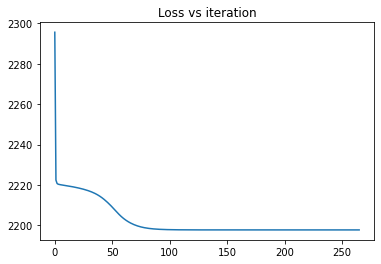

In [414]:
print_proven_EM(get_x1())

## 2c. x2


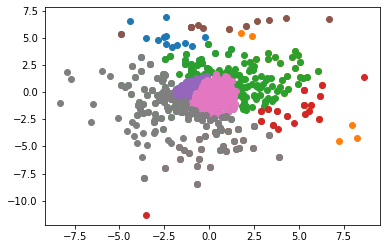

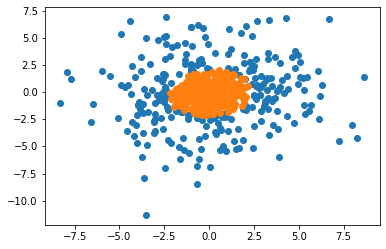

Cluster centroids (mu):
 [[ 0.17809451 -0.1251943 ]
 [ 0.01424414 -0.04651443]]
Cluster Covariance (sigma):
 [[[9.25806369 0.76781939]
  [0.76781939 9.41427438]]

 [[1.0625058  0.06633621]
  [0.06633621 0.88826244]]]
Proportions (pi):
 [0.48803561 0.51196439]


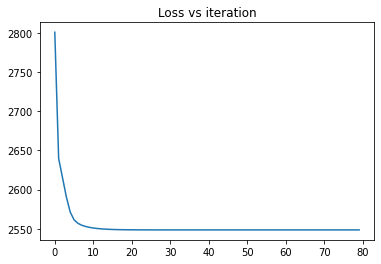

In [415]:
print_proven_EM(get_x2())
